In [13]:
import consts
from load_h5ad import load_data
from train import run_training
from plotting import plot_nuc_locs, plot_CB, plot_simulation
from model import model, simulation_model
from make_movie import make_movie

import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide.guides import AutoDelta
from pyro.infer.autoguide.initialization import init_to_sample
import pyro.poutine as poutine
from pyro.optim import Adam


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import os

In [10]:
run_ID = 'real_c18_wide'
sim = False
init = 'random'
epochs = 20000

c18_data = load_data('c18_slide_tags_data/cluster_18_CB_SB_counts_top_SBs.h5ad')
CBs = c18_data['CBs']
SBs = c18_data['SBs']
SB_locs = torch.tensor(consts.GET_SB_LOCS) * 1000

num_nuclei = len(CBs)
DBSCAN_data_dir = 'DBSCAN_data'

try:
    os.mkdir(DBSCAN_data_dir)
except:
    print('Directories already made...')

if sim == False:
    # Real Data - lad Cluster 18 data and convert it into a dense tensor for training
    confidently_mapped_h5ad_file = 'c18_slide_tags_data/cluster_18_CB_SB_counts_top_SBs.h5ad'
    data = load_data(confidently_mapped_h5ad_file)['matrix']
    data = torch.from_numpy(np.array(data.todense(), dtype=np.float32))

    ground_truth_df = pd.read_csv('slide_tags_data/gel_2_deep_cutoff_info.csv', index_col = 'CB')
    ground_truth_df = ground_truth_df[ground_truth_df['seurat_clusters'] == 18].drop('seurat_clusters', axis = 1)
    gt_nuclei_x_n, gt_nuclei_y_n = [], []
    for c18_CB in CBs:
        x_coord, y_coord = ground_truth_df.loc[c18_CB] / 1000.
        gt_nuclei_x_n.append(x_coord)
        gt_nuclei_y_n.append(y_coord)


    gt_nuclei_x_n = torch.tensor(gt_nuclei_x_n)
    gt_nuclei_y_n = torch.tensor(gt_nuclei_y_n)
else:
    if sim == 'line':
        width = 2.
        gt_nuclei_x_n = torch.arange(consts.R_LOC_X - width / 2, consts.R_LOC_X + width / 2, width / num_nuclei)
        gt_nuclei_y_n = torch.ones(num_nuclei) * consts.R_LOC_Y

    elif sim == 'c18':

        ground_truth_df = pd.read_csv('slide_tags_data/gel_2_deep_cutoff_info.csv', index_col = 'CB')
        ground_truth_df = ground_truth_df[ground_truth_df['seurat_clusters'] == 18].drop('seurat_clusters', axis = 1)
        gt_nuclei_x_n, gt_nuclei_y_n = [], []
        for c18_CB in CBs:
            x_coord, y_coord = ground_truth_df.loc[c18_CB] / 1000.
            gt_nuclei_x_n.append(x_coord)
            gt_nuclei_y_n.append(y_coord)

        gt_nuclei_x_n = torch.tensor(gt_nuclei_x_n)
        gt_nuclei_y_n = torch.tensor(gt_nuclei_y_n)
    elif sim == 'real':
        ground_truth_df = pd.read_csv('slide_tags_data/gel_2_deep_cutoff_info.csv', index_col = 'CB')
        ground_truth_df = ground_truth_df.drop('seurat_clusters', axis = 1)
        gt_nuclei_x_n, gt_nuclei_y_n = [], []
        for CB in CBs:
            x_coord, y_coord = ground_truth_df.loc[CB] / 1000.
            gt_nuclei_x_n.append(x_coord)
            gt_nuclei_y_n.append(y_coord)

        gt_nuclei_x_n = torch.tensor(gt_nuclei_x_n)
        gt_nuclei_y_n = torch.tensor(gt_nuclei_y_n)
    elif sim == 'uniform':
        radius = 2.5
        center_x, center_y = 3.2 * torch.ones(num_nuclei), 3.25 * torch.ones(num_nuclei)

        r_n = radius * torch.rand(num_nuclei).sqrt()
        theta_n = 2 * math.pi * torch.rand(num_nuclei)

        gt_nuclei_x_n = center_x + r_n * torch.cos(theta_n)
        gt_nuclei_y_n = center_y + r_n * torch.sin(theta_n)

    else:
        raise ValueError

simulation_model = poutine.condition(simulation_model, {'nuclei_x_n': gt_nuclei_x_n, 'nuclei_y_n': gt_nuclei_y_n})
data = simulation_model()

print(data.shape)

with open(f'{DBSCAN_data_dir}/DBSCAN_siulated_c18_index.csv', 'w') as f:
    f.write(f'cb,sb,reads,umi,x,y\n')
    dummy_reads = 10**3
    for CB_idx, CB_data in enumerate(data):
        CB = CBs[CB_idx]
        for SB_idx, UMIs in enumerate(CB_data):
            if UMIs > 0:
                SB = SBs[SB_idx]
                x_coord, y_coord = SB_locs[SB_idx]
                f.write(f'{CB},{SB},{dummy_reads},{UMIs},{x_coord},{y_coord}\n')
    
    
    
    

Directories already made...
torch.Size([203, 10331])


In [23]:
parameter_save_file = 'test_DR_param_indiv/test_DR_param_indiv_parameters/test_DR_param_indiv_best_parameters_epoch_2200.save'
pyro.get_param_store().load(parameter_save_file)

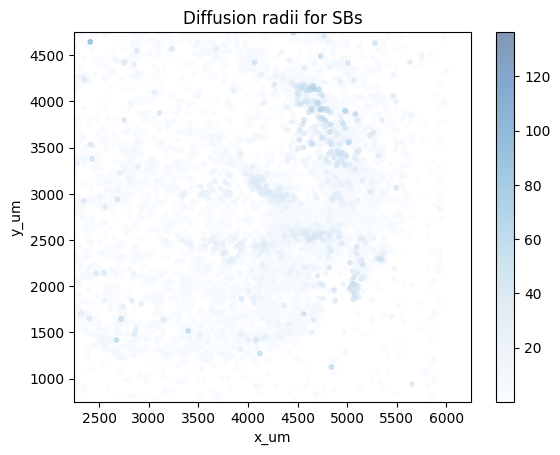

In [31]:
fig, ax = plt.subplots()
ax.set_title(f'Diffusion radii for SBs')
ax.set_xlabel('x_um')
ax.set_ylabel('y_um')
ax.set_xlim(2250,6250)
ax.set_ylim(750,4750)

sigma_SBs = pyro.param('sigma_SB_b').detach().numpy()
SB_LOCS = np.asarray(consts.GET_SB_LOCS) * 1000
x_SB_coords, y_SB_coords = SB_LOCS[:,0], SB_LOCS[:,1]
plotting_df = pd.DataFrame(data = {'x_coords': x_SB_coords, 'y_coords': y_SB_coords, 'sigma_SBs': sigma_SBs}).sort_values('sigma_SBs', ascending=True)
sc = ax.scatter(plotting_df['x_coords'], plotting_df['y_coords'], s = 10, c = plotting_df['sigma_SBs'], alpha = 0.5, cmap = 'Blues')

fig.colorbar(sc)
# plt.savefig(f'{run_ID}/{run_ID}_SB_scale_factors/SB_scale_factors_epoch_{epoch}_{run_ID}.png')
plt.show()